# Schritt 2 Deep Learning: Instrumenten-Klassifikation

# Import libraries

In [1]:
import os
import numpy as np
import librosa as lr
import pandas as pd
import keras
import pickle
import keras.initializers
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# Set directory for source files

ROOT = "all_samples_wav"
folders = os.listdir(ROOT) # names of subfolders
file_data = [] # filenames in each of the 58 folders

TARGET_SECONDS = 2
sr = 22050
target_num_samples = sr*TARGET_SECONDS

n_fft = 1024
hop_length = 512
n_mfcc = 13

# Statistics about the dataset

In [4]:
for label in tqdm(range(len(folders))):
    sub_dir = os.listdir(f'{ROOT}/{folders[label]}')
    file_data.append(sub_dir)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 25.18it/s]


In [5]:
amounts = []

for i in range(len(file_data)):
    amounts.append(len(file_data[i]))
col1 = np.array(folders)
col2 = np.array(amounts)
merge = {'folder': col1, 'amount': col2}

df = pd.DataFrame(merge, columns=['folder', 'amount'])
                   
print(f'Total amount of samples: {sum(amounts)}')

df

Total amount of samples: 13681


,folder,amount
0,banjo,74
1,bassoon,720
2,bass_clarinet,944
3,cello,889
4,clarinet,846
5,contrabassoon,710
6,cor_anglais,691
7,double_bass,852
8,flute,878
9,french_horn,652


Load audio data

In [6]:
# audio_data = []
# 
# for dirname, _, filenames in tqdm(os.walk(ROOT)):
#     for filename in filenames:
#         src = f'{dirname}/{filename}'
#         audio_data.append(lr.load(src))

Save/Load audio_waves array

In [7]:
# Save
# with open('audio_data.pickle', 'wb') as f:
#     pickle.dump(audio_data, f)

In [8]:
# Load
with open('audio_data.pickle', 'rb') as f:
    audio_data = pickle.load(f)

Create dataframe overview

In [9]:
fname = []
classID = []
num_samples = []

df1 = pd.DataFrame(np.array(audio_data, dtype=object), columns=['signal', 'samplerate'])

for i in range(df1.shape[0]):
    num_samples.append(len(df1['signal'].iloc[i]))
num_samples = np.array(num_samples)

for dirname, _, filenames in os.walk(ROOT):
    for filename in filenames:
        fname.append(filename)
        classID.append(dirname[16:])
fname = np.array(fname)
classID = np.array(classID)

df1['num samples'] = num_samples
df1['seconds'] = df1['num samples']/df1['samplerate']
df1['fname'] = fname
df1['classID'] = classID

# round seconds
df1['seconds'] = df1['seconds'].apply(pd.to_numeric, errors='coerce').round(1)

df1

,signal,samplerate,num samples,seconds,fname,classID
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,76608,3.5,banjo_A3_very-long_forte_normal.wav,banjo
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,77184,3.5,banjo_A3_very-long_piano_normal.wav,banjo
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,84096,3.8,banjo_A4_very-long_forte_normal.wav,banjo
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,69696,3.2,banjo_A4_very-long_piano_normal.wav,banjo
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,85248,3.9,banjo_A5_very-long_forte_normal.wav,banjo
...,...,...,...,...,...,...
13676,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,48960,2.2,violin_Gs6_1_mezzo-forte_natural-harmonic.wav,violin
13677,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,28800,1.3,violin_Gs6_1_piano_arco-sul-tasto.wav,violin
13678,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,34560,1.6,violin_Gs6_1_piano_natural-harmonic.wav,violin
13679,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22050,51840,2.4,violin_Gs6_phrase_pianissimo_arco-normal.wav,violin


Shortest sample length: 1728sm (~ 0.1 seconds), longest: 1711296sm (~ 77.6 seconds)
Average length in seconds: 1.9


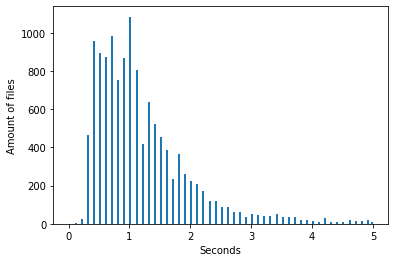

In [10]:
%matplotlib inline
x = df1['seconds']

plt.hist(x, density=False, bins=150, range=(0,5))  # density=False would make counts
plt.ylabel('Amount of files')
plt.xlabel('Seconds');

print(f"Shortest sample length: {np.min(df1['num samples'])}sm (~ {np.min(df1['seconds'])} seconds), longest: {np.max(df1['num samples'])}sm (~ {np.max(df1['seconds'])} seconds)")
print(f"Average length in seconds: {np.round(np.mean(df1['seconds']), decimals=1)}")

Bring all soundfiles to the desired length of 2 seconds

In [11]:
processed_audio = []

for i in range(len(audio_data)):
    signal = audio_data[i][0]
    
    # shorten if too long, right-pad if too short
    if len(signal) > target_num_samples:
        processed_audio.append(signal[:target_num_samples])
        
    if len(signal) < target_num_samples:
        num_missing_samples = target_num_samples - len(signal)
        last_dim_padding = (0, num_missing_samples)
        processed_audio.append(np.pad(signal, last_dim_padding, mode='constant'))
        
processed_audio = np.array(processed_audio, dtype=float)

Save/load processed_audio_data

In [12]:
# Save
# with open('processed_audio.pickle', 'wb') as f:
#     pickle.dump(processed_audio, f)

In [13]:
# Load
with open('processed_audio.pickle', 'rb') as f:
    processed_audio = pickle.load(f)

In [14]:
processed_audio.shape

(13681, 44100)

# Feature extraction

Methods and extraction

In [15]:
def mfcc_scale(mfcc):
    scaler = StandardScaler()
    mfcc = scaler.fit_transform(np.array(mfcc))
    return mfcc

def calc_mfcc(signal):
    return lr.feature.mfcc(y=signal, n_mfcc=n_mfcc, sr=sr)

In [16]:
mfcc_features = []

for i in tqdm(range(len(processed_audio))):
    mfcc_features.append(mfcc_scale(calc_mfcc(processed_audio[i])))
    
mfcc_features = np.array(mfcc_features)

100%|███████████████████████████████████████████████████████████████████████████| 13681/13681 [01:48<00:00, 126.56it/s]


Save/load mfcc_features

In [17]:
# Save
with open('mfcc_features.pickle', 'wb') as f:
    pickle.dump(mfcc_features, f)

In [18]:
# Load
# with open('mfcc_features.pickle', 'rb') as f:
#     mfcc_features = pickle.load(f)

In [19]:
print(processed_audio.shape)
print(mfcc_features.shape)

(13681, 44100)
(13681, 13, 87)


# Extract and plot a single sound file

ex. shortened file

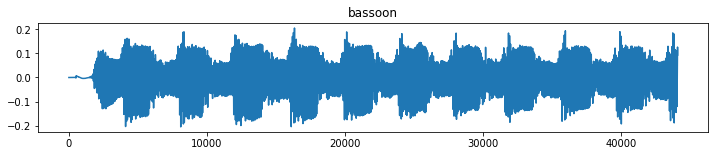

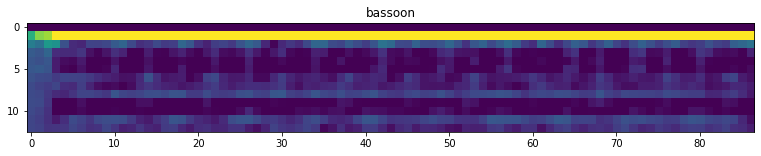

bassoon_C4_long_forte_tremolo.wav; original: 101376sm -> 44100sm


In [20]:
test_nr = 310
plt.figure(figsize=(12,2))
plt.plot(processed_audio[test_nr])
plt.title(f'{classID[test_nr]}')
plt.show()
plt.figure(figsize=(15, 2))
plt.imshow(mfcc_features[test_nr], vmin=0, vmax=1)
plt.title(classID[test_nr])
plt.show()
print(f'{fname[test_nr]}; original: {len(audio_data[test_nr][0])}sm -> {target_num_samples}sm')

ex. padded file

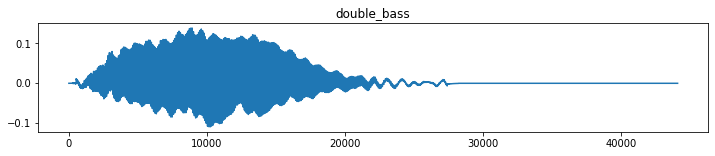

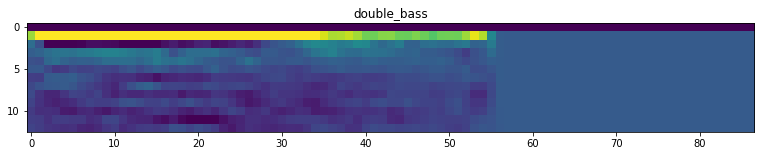

double-bass_As3_1_mezzo-piano_arco-normal.wav; original: 28224sm -> 44100sm


In [21]:
test_nr = 5001
plt.figure(figsize=(12,2))
plt.plot(processed_audio[test_nr])
plt.title(classID[test_nr])
plt.show()
plt.figure(figsize=(15, 2))
plt.imshow(mfcc_features[test_nr], vmin=0, vmax=1)
plt.title(classID[test_nr])
plt.show()
print(f'{fname[test_nr]}; original: {len(audio_data[test_nr][0])}sm -> {target_num_samples}sm')

Encoding the labels<br>
'banjo' -> '0',<br>
...<br>
'violin' -> '20'<br>
Followed by one-hot-encoding

In [22]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(classID)
label_encoded = label_encoded[:, np.newaxis]

In [23]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)

# Create train and test sets

Intuitive labelling for data, normalization of features, stratified splitting to account for<br>
the inbalances in the dataset

In [24]:
X = mfcc_features
y = one_hot_encoded
X = (X-X.min())/(X.max()-X.min()) # Normalization
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=8)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  stratify=y_train, 
                                                  test_size=0.25, 
                                                  shuffle=True, 
                                                  random_state= 8)

In [25]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [26]:
input_shape

(13, 87, 1)

In [27]:
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_test shape: {}".format(y_test.shape))
print("X_val shape: {}".format(y_train.shape))
print("y_val shape: {}".format(y_test.shape))

X_train shape: (8208, 13, 87)
X_test shape: (2737, 13, 87)
y_train shape: (8208, 20)
y_test shape: (2737, 20)
X_val shape: (8208, 20)
y_val shape: (2737, 20)


# Training

In [28]:
# Training parameters

num_epochs = 100
# num_steps = 1000
activation = 'relu'
last_act = 'Softmax'
kernel_init = 'he_normal'
dense_init = keras.initializers.HeNormal()
regularizer = l2(0.01)
padding = 'same'
loss = 'categorical_crossentropy'
optimizer = 'adam'
metrics = 'acc'
filter_dim = (3, 3)

# Early stopping parameters
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=3)

CNN Architecture

In [29]:
model = Sequential()
model.add(Conv2D(16, filter_dim, activation=activation, strides=(1, 1), padding=padding, input_shape=input_shape, kernel_initializer=kernel_init))
# model.add(MaxPool2D((2, 2), padding=padding))

model.add(Conv2D(32, filter_dim, activation=activation, strides=(1, 1), padding=padding, kernel_initializer=kernel_init))
# model.add(MaxPool2D((2, 2), padding=padding))

model.add(Conv2D(64, filter_dim, activation=activation, strides=(1, 1), padding=padding, kernel_initializer=kernel_init))
model.add(MaxPool2D((2, 2), padding=padding))

model.add(Conv2D(128, filter_dim, activation=activation, strides=(1, 1), padding=padding, kernel_initializer=kernel_init))
model.add(MaxPool2D((2, 2), padding=padding))

model.add(Flatten())
model.add(Dense(512, activation=activation, kernel_initializer=dense_init, kernel_regularizer=regularizer))
model.add(Dropout(0.3))
model.add(Dense(1024, activation=activation, kernel_initializer=dense_init, kernel_regularizer=regularizer))
model.add(Dropout(0.2))
model.add(Dense(512, activation=activation, kernel_initializer=dense_init, kernel_regularizer=regularizer))
model.add(Dense(20, activation=last_act))

model.compile(loss=loss, optimizer=optimizer, metrics=[metrics])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 13, 87, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 87, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 87, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 7, 44, 64)        0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 44, 128)        73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 22, 128)       0         
 2D)                                                    

Train

In [31]:
history = model.fit(X_train, y_train, 
                    # steps_per_epoch=num_steps,
                    initial_epoch=0,
                    epochs=num_epochs, 
                    validation_data=(X_val, y_val), 
                    shuffle=True,
                    callbacks=[callback])

Epoch 1/100
257/257 [==============================] - 15s 40ms/step - loss: 11.3621 - acc: 0.1098 - val_loss: 3.8793 - val_acc: 0.1480
Epoch 2/100
257/257 [==============================] - 9s 36ms/step - loss: 2.9051 - acc: 0.2880 - val_loss: 2.1198 - val_acc: 0.4547
Epoch 3/100
257/257 [==============================] - 9s 36ms/step - loss: 1.9303 - acc: 0.4934 - val_loss: 1.4896 - val_acc: 0.6546
Epoch 4/100
257/257 [==============================] - 9s 37ms/step - loss: 1.5381 - acc: 0.6390 - val_loss: 1.2171 - val_acc: 0.7588
Epoch 5/100
257/257 [==============================] - 9s 36ms/step - loss: 1.3293 - acc: 0.7105 - val_loss: 1.0379 - val_acc: 0.8118
Epoch 6/100
257/257 [==============================] - 9s 36ms/step - loss: 1.1593 - acc: 0.7682 - val_loss: 1.0530 - val_acc: 0.8067
Epoch 7/100
257/257 [==============================] - 9s 36ms/step - loss: 1.0468 - acc: 0.8036 - val_loss: 0.9467 - val_acc: 0.8443
Epoch 8/100
257/257 [==============================] - 9s 36

Save/load the model

In [32]:
model.save("cnn_philharmonia.h5")
#model = keras.models.load_model("cnn_philharmonia.h5")

Export model.json and *.bins with weights

In [33]:
!tensorflowjs_converter --input_format keras "cnn_philharmonia.h5" ./jsmodel

# Evaluation

loss 0.5710670948028564
val_loss: 0.5702022910118103


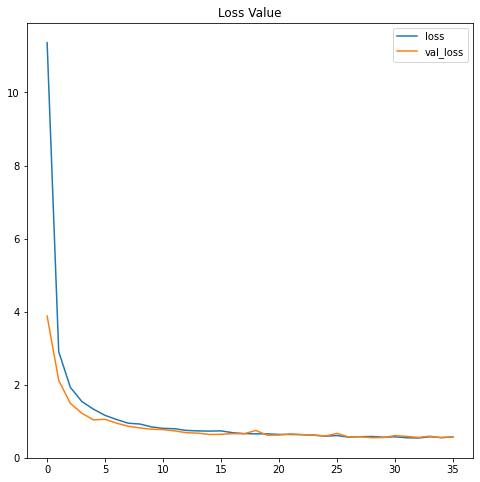

acc: 0.9356725215911865
val_acc: 0.9367690086364746


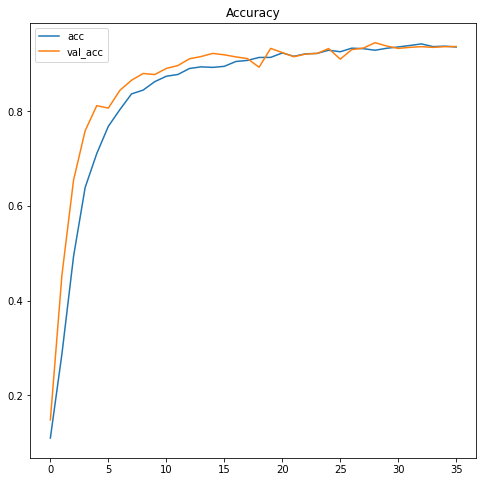

In [34]:
plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss', history.history['loss'][-1])
print('val_loss:', history.history['val_loss'][-1])
plt.show()
plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
print('acc:', history.history['acc'][-1])
print('val_acc:', history.history['val_acc'][-1])
plt.show()

In [35]:
predictions = model.predict(X_test)

86/86 [==============================] - 1s 9ms/step


In [36]:
predictions = np.argmax(predictions, axis=1)
y_test = one_hot_encoder.inverse_transform(y_test)

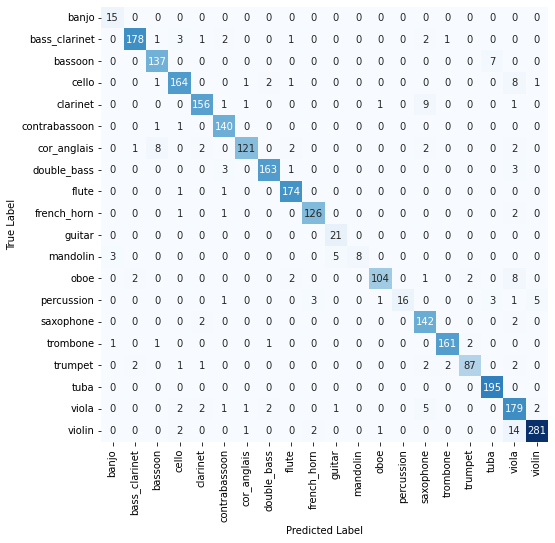

In [37]:
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [38]:
# Classification report
print("\nClassification report:\n", classification_report(y_test, predictions, target_names=folders))


Classification report:
                precision    recall  f1-score   support

        banjo       0.79      1.00      0.88        15
      bassoon       0.97      0.94      0.96       189
bass_clarinet       0.92      0.95      0.94       144
        cello       0.94      0.92      0.93       178
     clarinet       0.95      0.92      0.94       169
contrabassoon       0.93      0.99      0.96       142
  cor_anglais       0.97      0.88      0.92       138
  double_bass       0.97      0.96      0.96       170
        flute       0.96      0.99      0.97       176
  french_horn       0.96      0.97      0.97       130
       guitar       0.78      1.00      0.88        21
     mandolin       1.00      0.50      0.67        16
         oboe       0.97      0.87      0.92       119
   percussion       1.00      0.53      0.70        30
    saxophone       0.87      0.97      0.92       146
     trombone       0.98      0.97      0.98       166
      trumpet       0.96      0.90     